# Spatial display for Wetlands Insight Tool results <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatibility:** Notebook currently compatible with only the `NCI VDI` environment


* **Special requirements:** 
    * If running on the [NCI](https://nci.org.au/), ensure that `module load dea` is   run prior to launching this notebook
    * Check you have the latest version of the `wit_tooling package` by 
      copying and pasting the following code into a cell below and running the cell
    `!pip install --user git+git://github.com/GeoscienceAustralia/wit_tooling`
      
      
* **Products used:** 
    * Collection 2 Landsat Surface Reflectance: 
    [ls5_nbart_albers](https://explorer.dea.ga.gov.au/ls5_nbart_albers),
    [ls7_nbart_albers](https://explorer.dea.ga.gov.au/ls7_nbart_albers),
    [ls8_nbart_albers](https://explorer.dea.ga.gov.au/ls8_nbart_albers)
    * Collection 2 Landsat Fractional Cover, 
    generated using the Joint Remote Sensing Research Program algorithm: 
    [ls5_fc_albers](https://explorer.dea.ga.gov.au/ls5_fc_albers),
    [ls7_fc_albers](https://explorer.dea.ga.gov.au/ls7_fc_albers),
    [ls8_fc_albers](https://explorer.dea.ga.gov.au/ls8_fc_albers)
    * Water Observations from Space, 
    generated using the Geoscience Australia Algorithm:
    [wofs_albers](https://explorer.sandbox.dea.ga.gov.au/wofs_albers)



## Background
The Spatial Wetlands Insight Tool is a tool in development to display the coverage of water, "wetness" and vegetation fractional cover in a wetland spatially. It is generated off existing Wetlands Insight Tool temporal runs. 

## Description
This notebook uses an existing Wetlands Insight Tool temporal plot, 
generated from an existing WIT run, to create a spatial plot of water, "wetness", green/photosynthetic vegetation, dry/non-photosynthetic vegetation, and bare soil for a chosen observation date. 

1. First we load the existing WIT data from either: 
    * a saved csv location
    * a shapefile to retrieve the existing WIT data from the database of previous runs
    * a csv from an Amazon s3 data bucket
2. Then we choose a time of interest to plot Spatial WIT
3. Finally we output Spatial WIT to a file for each cover type
***

Before running this notebook:
-----------------------------
* Follow the instructions under `Special Requirements` above to load `dea` and install `wit_tooling`

## Load packages

In [1]:
# import all the necessary packages in this cell
import pandas as pd
import numpy as np
import fiona
import geopandas as gpd


from datacube.utils.cog import write_cog

from bokeh.io import curdoc, output_notebook, show
from bokeh.layouts import layout
from bokeh.models import (CheckboxGroup, Select, ColumnDataSource, HoverTool, YearsTicker, Legend,
                          CustomJS, LegendItem, field, Range1d, Circle, Button, RadioGroup, TextInput, WheelZoomTool,
                          ResetTool, BoxZoomTool, SaveTool, LinearColorMapper, Label)
from bokeh.models.formatters import DatetimeTickFormatter
from bokeh.models.glyphs import Text
from bokeh.colors import RGB
from bokeh.plotting import figure
import datetime

from os import path
import os, sys, logging
import seaborn as sns
import ssl

from wit_tooling import load_wit_data, query_datasets, construct_product, load_wofs_fc, generate_raster, spatial_wit

In [2]:
output_notebook()
ssl._create_default_https_context = ssl._create_unverified_context

_LOG = logging.getLogger(__name__)
stdout_hdlr = logging.StreamHandler(sys.stdout)
formatter = logging.Formatter('[%(asctime)s.%(msecs)03d - %(levelname)s] %(message)s')
stdout_hdlr.setFormatter(formatter)
_LOG.addHandler(stdout_hdlr)
_LOG.setLevel(logging.DEBUG)

Loading BokehJS ...

### Global variables
If you are using a shapefile, csv file, or Amazon s3 link to the existing WIT run, 
the path must be set in the cell below this cell:

* `shapefile`: NCI path to shapefile 
(e.g. `'/g/data1a/r78/DEA_Wetlands/shapefiles/ramsar_wetlands_3577_20190403.shp'`). 
You must have permissions to the project directory,
and the shapefile must be in [Australian Albers EPSG 3577 projection](https://spatialreference.org/ref/epsg/gda94-australian-albers/)
* `csv_file`: NCI path to WIT results CSV (e.g. `'/g/data1a/u46/users/ea6141/dea-notebooks/Spatial_WIT/sample_data/Western Port_Western Port_VIC_19.csv'`)
* `pd_yaml`: Yaml file necessary to generate WIT 
e.g. `'/g/data/u46/users/ea6141/wit_tooling/aux/fc_pd.yaml'`). 
Specifies input datasets.
* `s3_url`: Amazon s3 url link to pre-generated WIT csvs folder 
(e.g. `'https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/Wetlands_Insight_Tool/WIT_v3'`). 


In [3]:
# put global variables in this cell
shapefile = '/g/data/r78/DEA_Wetlands/shapefiles/ramsar_wetlands_3577_20190403.shp'
#csv_file = '/g/data1a/u46/users/ea6141/dea-notebooks/Spatial_WIT/sample_data/Western Port_Western Port_VIC_19.csv'
pd_yaml = '/g/data/u46/users/ea6141/wit_tooling/aux/fc_pd.yaml'
s3_url = 'https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/Wetlands_Insight_Tool/WIT_v3/Kerang%20Wetlands_Hird%20Swamp_VIC_17.csv'

In [4]:
def save_geotiff(spatial_wit_xr, filename, force=False):
    """
        save spatial WIT result to geotiffs, each band will be output to individual tiff
        input:
            an xarray Dataset of spatial WIT
            overwrite existing file if force=True, otherwise no output
        output:
            multiple cloud-optimized geotiffs (cogs) on disk
    """
    for var in spatial_wit_xr.data_vars:       
        #create file name per band
        band_output = file_name + "_" + var + ".tif"
        if path.exists(band_output):
            _LOG.warning("output geotif %s exists", band_output)
            if force:
                _LOG.warning("existing geotif %s will be overwritten", band_output)
                os.remove(band_output)
            else:
                continue
        spatial_wit_xr[var].attrs.update(spatial_wit_xr.attrs)
        write_cog(spatial_wit_xr[var], band_output, blocksize=16)
    return

## Load WIT data using one of the methods in the cell below

In [5]:
# A list we wanna explore
#poly_candidates = {1: 1, 5: 5, 116: 116, 103: 103, 2: 2, 112: 112}
poly_candidates = {42:42}

In [6]:
# todo: iterate over all possible loading routes,
# i.e., database and csv on s3 (not responsible for local csv, users supposed to know)
# load wit data from database with a chosen shape
with fiona.open(shapefile) as allshapes:
    shape_crs = allshapes.crs_wkt
    shape_list = iter(allshapes)
    while True:
        shape = next(shape_list)
        if int(shape['id']) == poly_candidates[42]:
            break
    #polyName = shape['properties'].get('WetlandNam', '')
    poly_outline = np.array(shape['geometry']['coordinates'][0])
   # s3_filename = 'area_percent_' + shape['id'] + '_0.csv'
    wit_data = load_wit_data(s3_url='https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/Wetlands_Insight_Tool/WIT_v3/Kerang%20Wetlands_Hird%20Swamp_VIC_17.csv')

### Check the shapefile to make sure we've got the correct polygon

In [7]:
shape_df = gpd.read_file(shapefile)

In [8]:
shape_df[42:43]

,REFCODE,RAMSAR_NAM,WETLAND_NA,STATE,JURISDICTI,DESIGNATIO,TOTAL_SITE,GAZETTED_A,SOURCE,METADATA_U,WETLANDSDB,AREA_HA,geometry
42,17,Kerang Wetlands,Hird Swamp,VIC,VIC,1982-12-15,0.0,9419.0,Department of Environment and Primary Industri...,http://services.land.vic.gov.au/SpatialDatamar...,http://www.environment.gov.au/cgi-bin/wetlands...,433.68127,"POLYGON ((1090599.724 -3968110.105, 1090900.93..."


Hird Swamp


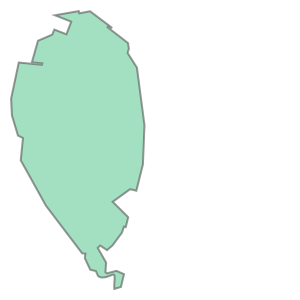

In [9]:
#Check that #42 is Hird Swamp
print(shape_df['WETLAND_NA'][42])
polyName = shape_df['WETLAND_NA'][42]
shape_df['geometry'][42]

### Spatial wit for the chosen shape

In [10]:
# it's helpful to get the location of data rather than load them
# and it will save you time without querying database multiple times
#time_range = (wit_data.utc_time.min(), wit_data.utc_time.max())
time_range = (wit_data.utc_time.min(), wit_data.utc_time.max())

In [11]:
#build a product for our data using the yaml file to specify which datasets we need
fc_product = construct_product(pd_yaml)
datasets = query_datasets(fc_product, shape, shape_crs, time_range)
_LOG.debug("Query datasets %s", datasets)

[2021-05-04 13:26:55,416.416 - DEBUG] Query datasets <VirtualDatasetBox of shape {'time': 1091, 'y': 152, 'x': 74}>


In [12]:
#datasets.box.time
#datasets_time_source = ColumnDataSource(data=dict(time=pd.to_datetime(datasets.box.time.data).astype('str')))
#datasets_time_source
#wit_data.utc_time[0:20]

In [13]:
# take first time slice to init spatial wit plot
time_slice = np.datetime64(wit_data.utc_time[1])
_LOG.debug("load time slice %s", time_slice)

[2021-05-04 13:26:55,438.438 - DEBUG] load time slice 1987-09-30T23:42:36.500000


In [14]:
fc_wofs_data = load_wofs_fc(fc_product, datasets, time_slice)
# mask by the geometry of given polygon"

/g/data/v10/public/modules/dea/20201217/lib/python3.6/site-packages/datacube/virtual/utils.py:13: UserWarning: select_unique may have failed: {'crs': 'EPSG:3577', 'grid_mapping': 'spatial_ref'} is not the same as {'crs': 'EPSG:3577'}
  .format(first, other))


In [15]:
# first parameter of generate_raster is a tuple of (shape geometry, [integer of shape id])

mask = generate_raster([(shape['geometry'], int(shape['id']))], datasets.geobox)
fc_wofs_perc = spatial_wit(fc_wofs_data, mask)

/g/data/v10/public/modules/dea/20201217/lib/python3.6/site-packages/datacube/utils/geometry/_base.py:301: DeprecationWarning: Please use `str(crs)` instead of `crs.crs_str`
  warnings.warn("Please use `str(crs)` instead of `crs.crs_str`", category=DeprecationWarning)


In [61]:
#multiply our 
wit_data.iloc[:,1:] = wit_data[wit_data.columns[1:]].apply(lambda x: x * 100)

Create a wit temporal plot with wit spatial wit plots above it

In [64]:
def plot_doc(doc):
    '''code to create the WIT temporal and spatial plots '''
    #tell bokeh the data comes from a pandas dataframe
    source = ColumnDataSource(data=wit_data)
    
    for i in range(10):
        source.data['dummy'+str(i)] = np.ones(source.data['utc_time'].shape) * i * 10

    #set up color palate for bokeh WIT plot
    pal = [sns.xkcd_rgb["cobalt blue"],
           sns.xkcd_rgb["neon blue"],
           sns.xkcd_rgb["grass"],
           sns.xkcd_rgb["beige"],
           sns.xkcd_rgb["brown"]]  

    #lets put a title on the plot
    title =f'Percentage of area dominated by WOfS, Wetness, Fractional Cover for {polyName}'    

    #set up the x axis to recognise date and time. Note that you will only see the days when you zoom in.
    wit_plot = figure(plot_width=1200, 
              plot_height = 400, 
              x_axis_type='datetime',
             title=title, tools=["box_select", ResetTool(), BoxZoomTool(dimensions="width")])
    
    hovernames = []
    nonselected_circle = Circle(fill_alpha=0, fill_color=None, line_color=None)
    for i in range(10):
        circle_group_name = 'circlegroup' + str(i)
        renderer = wit_plot.circle(y="dummy" + str(i), x= 'utc_time', size=20, fill_color=None, 
                        line_alpha=0, source = source, muted_color="white", muted_alpha=0, name=circle_group_name)
        renderer.nonselection_glyph = nonselected_circle
        hovernames.append(circle_group_name)
    wit_plot.varea_stack(['water', 
                  'wet',
                  'green',
                  'dry',
                  'bare'], x= 'utc_time', name = "stackplot", color=pal, fill_alpha=0.7, source = source, 
                  legend_label=["water","wet","green","dry","bare"], muted_color="grey", muted_alpha=0.2)
    wit_plot.sizing_mode = "scale_width"

    #align the title in the centre
    wit_plot.title.align= "center"
    wit_plot.title.text_font_size="12pt"

    #label axes
    wit_plot.yaxis.axis_label=("percentage of polygon classified as type")
    wit_plot.yaxis.axis_label_text_font_size="8pt"

    #we need screen units to put the attribution label under the plot. Don't ask why.
    label_opts = dict(
        x=0, 
        y=0,
        x_units='screen', 
        y_units='screen',
        text_font_style="italic", 
        text_font_size="8.5pt")

    #underplot context
    msg1 = 'The Fractional Cover algorithm developed by the Joint Remote Sensing Research Program\n\
    and the Water Observations from Space algorithm developed by Geoscience Australia are used in the production of this data'
    caption1 = Label(text=msg1, **label_opts)

    wit_plot.add_layout(caption1, 'below')

    wit_plot.xaxis.formatter=DatetimeTickFormatter()
    wit_plot.xaxis.ticker = YearsTicker(interval=1)
    wit_plot.xaxis.major_label_orientation = 45
    
    #set the new WIT graph ranges.
    left, right, bottom, top = source.data['utc_time'][0], source.data['utc_time'][-1], 0, 100 #set 
    wit_plot.x_range=Range1d(left, right)
    wit_plot.y_range=Range1d(bottom, top)
    wit_plot.xaxis.bounds=(left,right)
    wit_plot.yaxis.bounds=(bottom,top)

    #now we want to overplot the data on the plot
    #create rectangle borders for no-data times (SLC-off only)
    LS5_8_gap_start = datetime.datetime(2011,11,1)
    LS5_8_gap_end = datetime.datetime(2013,4,1)

    #plot our dead satellite rectangle
    wit_plot.hbar(y=50, 
           height=100,
           left=LS5_8_gap_start, 
           right=LS5_8_gap_end, 
           name ="LS7 SLC-OFF",
           color="white", 
           alpha=0.5, 
           hatch_color="white", 
           hatch_pattern='/',
           hatch_alpha=0.6,
           line_color="white",
           line_width =2,
           line_alpha=0.6)

    wit_plot.legend.location="bottom_left"
    wit_plot.legend.background_fill_alpha=0.5
    wit_plot.legend.border_line_alpha=0.5
    wit_plot.legend.label_text_font_size="9pt" 

    #reverse the legend 
    wit_plot.legend[0].items.reverse()
    
    wit_hover = HoverTool(names = hovernames,
                      tooltips = [
        ("observation", "$index"),
        ("date", "@utc_time{%F}"),
        ("bare","@bare{0.0}%"),
        ("dry", "@dry{0.0}%"),
        ("green","@green{0.0}%"),
        ("wet","@wet{0.0}%"),
        ("water","@water{0.0}%")],     
                    formatters=
        {"@utc_time":"datetime"})

    #trialling different ways of getting the tools to work. Both adding tools and including in the figure work.
    wit_plot.add_tools(wit_hover, WheelZoomTool(), SaveTool())
    
    # down below is interactivity between plots
    # WARNING: DON'T MODIFY UNLESS YOU ABSOLUTELY KNOW WHAT YOU'RE DOING
    def sw_update(attrname, old, new):
        time_slice = new
        fc_wofs_data = load_wofs_fc(fc_product, datasets, np.datetime64(time_slice))
        fc_wofs_perc = spatial_wit(fc_wofs_data, mask)
        for var in fc_wofs_perc.data_vars:
            sw_source.data[var] = [np.flip(fc_wofs_perc[var].data[0], axis=0)]
        sw_plot.title.text = "Spatial wit for time %s" % time_slice

    datasets_time_source = ColumnDataSource(data=dict(time=pd.to_datetime(datasets.box.time.data).astype('str')))
    wit_time_source = ColumnDataSource(data=dict(time=wit_data.utc_time.astype('str')))
    selected_time_slice = ColumnDataSource(data=dict(time=[]))
    time_select = Select(title="time slice", value='', options=list(wit_time_source.data['time']), 
                         height=50, width=200, sizing_mode="fixed")
    time_select.on_change('value', sw_update)
    
    def minmax_time_update(attrname, old, new):
        if radio_group.active == 0:
            time_source = wit_time_source.data['time']
        elif radio_group.active == 1:
            time_source = datasets_time_source.data['time']
        if minmax_time_input.value != "":
            min_time = minmax_time_input.value.split(";")[0]
            max_time = minmax_time_input.value.split(";")[1]
            time_source = time_source[(time_source >= min_time) & (time_source <= max_time)]
        time_source = list(time_source)
        time_select.options = time_source
        time_select.value = time_source[0]
        
    minmax_time_input =  TextInput(value="")
    minmax_time_input.on_change('value', minmax_time_update)
    
    radio_group = RadioGroup(labels=["time slices from wit results", "time slices from available datasets"], 
                             active=0, height=50, width=250, sizing_mode='fixed')
    radio_group.on_change('active', minmax_time_update)
    
    js_code = """
        const inds=cb_obj.indices;
        var min_index = inds[0];
        var max_index = inds[0]
        var data_s = source.data;
        for (var i=0; i<inds.length; i++) {
            max_index = Math.max(max_index, inds[i]);
            min_index = Math.min(min_index, inds[i]);
        }
        target_minmax.value = data_s['time'][min_index] + ";" + data_s['time'][max_index];
    """
    js_callback = CustomJS(args={'source': wit_time_source, 'target_minmax': minmax_time_input}, 
                           code=js_code)
    source.selected.js_on_change('indices', js_callback)
    
    def reset_time_selection(event):
        if radio_group.active == 0:
            options_input = wit_time_source.data['time']
        elif radio_group.active == 1:
            options_input = datasets_time_source.data['time']
        time_select.options = list(options_input)
        minmax_time_input.value = ""
        
    reset_button = Button(label='reset time selection', height=50, width=80, sizing_mode='fixed', button_type='success')
    reset_button.on_click(reset_time_selection)
    # above is interactivity between plots
    
    # down below is spatial wit plot
    image_list = {}
    color_map_dict = {}
    # all below is to setup the pallete
    transparent_white = RGB(255, 255, 255, 0)
    colbat_blue = [RGB(3, 10, 167, 1)]
    neon_blue = [RGB(4, 217, 255, 1)]
    grass_green = [RGB(63, 155, 11, t) for t in np.arange(0.1, 1, 0.1)]
    soil_brown = [RGB(96, 70, 15, t) for t in np.arange(0.1, 1, 0.1)]
    dry_biege = [RGB(230, 218, 166, t) for t in np.arange(0.1, 1, 0.1) ]
    var_colors = [soil_brown, grass_green, dry_biege, neon_blue, colbat_blue]
    for var, cm in zip(fc_wofs_perc.data_vars, var_colors):
        image_list[var] = [np.flip(fc_wofs_perc[var].data[0], axis=0)]
        color_map_dict[var] = LinearColorMapper([transparent_white]+cm, low=0, high=100,
                                   nan_color=transparent_white)
    sw_source = ColumnDataSource(data=image_list)

    # do the image plot
    sw_plot = figure(plot_width=900, plot_height = 900,
             tooltips = [
        ("x", "$x"),
        ("y", "$y"),
        ("bare","@BS"),
        ("dry", "@NPV"),
        ("green","@PV"),
        ("wet","@TCW"),
        ("water","@water")])
    

    for var in fc_wofs_perc.data_vars:
        sw_plot.image(image=var, source=sw_source, x=fc_wofs_data.x.data.min(), y=fc_wofs_data.y.data.min(),
            dh=(fc_wofs_data.y.data.max() - fc_wofs_data.y.data.min()),
            dw=(fc_wofs_data.x.data.max() - fc_wofs_data.x.data.min()),
            color_mapper = color_map_dict[var])
    sw_plot.line(poly_outline[:,0], poly_outline[:,1], line_width=3)
    sw_plot.y_range.update(start=poly_outline[:,1].min(), end=poly_outline[:,1].max())
    sw_plot.x_range.update(start=poly_outline[:,0].min(), end=poly_outline[:,0].max())
    
    sw_plot.title.text = "Spatial wit at time %s" % time_slice
    sw_plot.title.text_font_size="12pt"
    # above is spatial wit plot
    
    layouts = layout([[radio_group, time_select, reset_button],
        [wit_plot],[sw_plot]
        ], sizing_mode='scale_both')
    doc.add_root(layouts)

In [66]:
show(plot_doc, notebook_url="http://localhost:8889")
#notebook_url is the server address of jupyter notebook, change accordingly

In [19]:
# save spatial WIT as geotiff
# each variable will be output to individual COG
# file_name works as prefix, the final output file name will be "file_name_bandname", e.g. "test_BS.tif"
# by default force=False := not overwriting existing geotif
file_name = "test_" + str(time_slice)
save_geotiff(fc_wofs_perc, file_name, force=False)

[2021-05-04 13:26:56,406.406 - WARNING] output geotif test_1987-09-30T23:42:36.500000_BS.tif exists


[2021-05-04 13:26:56,409.409 - WARNING] output geotif test_1987-09-30T23:42:36.500000_PV.tif exists


[2021-05-04 13:26:56,412.412 - WARNING] output geotif test_1987-09-30T23:42:36.500000_NPV.tif exists


[2021-05-04 13:26:56,414.414 - WARNING] output geotif test_1987-09-30T23:42:36.500000_TCW.tif exists


[2021-05-04 13:26:56,419.419 - WARNING] output geotif test_1987-09-30T23:42:36.500000_water.tif exists


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** June 16 2020

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)

**Tags**: :index:`no_testing`,:index:`NCI compatible`,:index:`landsat 5`, :index:`landsat 7`,  :index:`landsat 8`, :index:`dea_plotting`, :index:`time series`